<h1>Text Sentiment Analysis for Twitter Posts</h1>

Objective:
- Find out the different sentiment levels (negative, neutral, positive) among the posts and generate word clouds to discover key motivations / beliefs driving the sentiments

In [1]:
# pip install vaderSentiment

In [2]:
# pip install boto3

In [3]:
# pip install seaborn --upgrade

In [4]:
import pandas as pd
import numpy as np
import os
import re
import plotly.express as px
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.style as style
import matplotlib
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jlrqq/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
analyser = SentimentIntensityAnalyzer()

In [6]:
# https://github.com/cjhutto/vaderSentiment#about-the-scoring
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05

def sentiment_analyzer_score(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

In [7]:
# Read Twitter Data from Local CSV

tweets = pd.read_csv('../Twitter_Data/Twitter_Covid-19_Lockdown_5000.csv', index_col=0)

print(tweets.shape)
tweets.head()

(3750, 10)


,conversation_id,id,edit_history_tweet_ids,text,created_at,withheld.copyright,withheld.country_codes,author_name,orginal_text,original_text
author_id,,,,,,,,,,
495071269,1640204550631043072,1640204550631043072,['1640204550631043072'],RT @Chris_EvansMP: Today marks three years sin...,2023-03-27T04:10:13.000Z,NaN,NaN,BarnettElaine,Today marks three years since the UK went int...,Today marks three years since the UK went int...
1564131612505149440,1639919857012469760,1640204157683417089,['1640204157683417089'],@RoastSmith_ I used play Fortnite a lot on my ...,2023-03-27T04:08:39.000Z,NaN,NaN,tanseus1,@RoastSmith_ I used play Fortnite a lot on my ...,@RoastSmith_ I used play Fortnite a lot on my ...
1548020151814987779,1640202097772601345,1640202097772601345,['1640202097772601345'],RT @Somali_ICS: If it wasn't for #Tiktok there...,2023-03-27T04:00:28.000Z,NaN,NaN,Somali_ICS,If it wasn't for #Tiktok there would've been ...,If it wasn't for #Tiktok there would've been ...
27968588,1640194922799144961,1640194922799144961,['1640194922799144961'],@NYCMayor @ericadamsfornyc time to change cour...,2023-03-27T03:31:57.000Z,NaN,NaN,vliscony,@NYCMayor @ericadamsfornyc time to change cour...,@NYCMayor @ericadamsfornyc time to change cour...
1428236322838220802,1640190517093990400,1640190517093990400,['1640190517093990400'],Feeling in the dumps because of lockdown? \nHe...,2023-03-27T03:14:27.000Z,NaN,NaN,CovidHelpBot,Feeling in the dumps because of lockdown? \nHe...,Feeling in the dumps because of lockdown? \nHe...


In [8]:
# Read Twitter Data from S3 

# import pandas as pd
# import boto3
# import io

# AWS_ACCESS_KEY_ID = "*"
# AWS_SECRET_ACCESS_KEY = "*"
# bucket = "is434-last-sem-best-sem"
# file_name = "data-lake/tweeter_data.csv"

# # Create connection to S3 and all buckets within S3
# s3 = boto3.client(
#     's3',
#     aws_access_key_id=AWS_ACCESS_KEY_ID,
#     aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
# )

# # Get object and file (key) from bucket
# obj = s3.get_object(Bucket= bucket, Key= file_name) 

# tweets = pd.read_csv(io.BytesIO(obj['Body'].read()))
# tweets

In [9]:
# Extract Text from DataFrame into a List

tweet_text_list = tweets['original_text'].tolist()
tweet_text_list

[' Today marks three years since the UK went into lockdown.  \n\nOn this National Day of Reflection, I visited the @CovidMemo…',
 '@RoastSmith_ I used play Fortnite a lot on my Android in COVID -19 lockdown and Chapter 2 Midas revenge was the best one',
 " If it wasn't for #Tiktok there would've been a mental health crisis in the US during the 2020 pandemic Stay-At-Home Orders.…",
 '@NYCMayor @ericadamsfornyc time to change course @NYCHealthCommr\nhttps://t.co/bqGj1ngOp8',
 'Feeling in the dumps because of lockdown? \nHere are some tips to keep on top of your mental health! \nhttps://t.co/Tp4JTvVk0A https://t.co/MiGsNOSXpA',
 ' Eddie Griffin speaks the truth about Sheep and the Covid 19 shot \n\n#COVID19 #FauciLied #FauciFiles #Agenda2030 #KlausSchw…',
 " The Klaus Schwab book proves the virus was intentional. Publication July 2020. Lockdown started March 2020, and wasn't ca…",
 ' Bheed Trailer Removed From YouTube Amid Backlash Over Negative Depiction Of COVID-19 Lockdown. https://t.c

In [10]:
# Clean Text Function

def clean_tweet(comments):

    test_sentences = sent_tokenize(comments)
    test_sentences

    tokenizer = RegexpTokenizer(r'\w+')
    test_words = tokenizer.tokenize(comments)
    test_words_lower = list(map(lambda x: x.lower(), test_words)) 

    stop_words = stopwords.words('english')
    # print(stop_words)
    stop_words2 = ['co', 'covid', 'covid19', 'coronavirus', 'lockdown', 'covid19 lockdown','&amp', 'amp']

    filtered_test_words = []

    for w in test_words_lower:
        if w not in stop_words and w not in stop_words2:
            filtered_test_words.append(w)

    porter_stemer = PorterStemmer()

    stemed_filter_test_words = []
    for i in filtered_test_words:
        stemed_filter_test_words.append(porter_stemer.stem(i))

    join_words = " ".join([x for x in stemed_filter_test_words])

    return join_words

In [11]:
# Extract processed text

processed_text = [clean_tweet(tw) for tw in tweet_text_list]
processed_text

['today mark three year sinc uk went nation day reflect visit covidmemo',
 'roastsmith_ use play fortnit lot android 19 chapter 2 mida reveng best one',
 'tiktok would mental health crisi us 2020 pandem stay home order',
 'nycmayor ericadamsfornyc time chang cours nychealthcommr http bqgj1ngop8',
 'feel dump tip keep top mental health http tp4jtvvk0a http migsnosxpa',
 'eddi griffin speak truth sheep 19 shot faucili faucifil agenda2030 klausschw',
 'klau schwab book prove viru intent public juli 2020 start march 2020 ca',
 'bheed trailer remov youtub amid backlash neg depict 19 http 1yqekntwvd',
 'longcovid three year nz first 19 mani move long',
 'tiktok would mental health crisi us 2020 pandem stay home order',
 'longcovid three year nz first 19 mani move long',
 'br_cse_iitb himanshi_doc real reason profit globalist goal http m6qw20h46t',
 '05 04 20 ann reminisc past concert festiv attend uncertainti length 19 http ndel14qenm http sy1j5do1to',
 'tiktok would mental health crisi us 2

In [12]:
# Add processed text into the DataFrame

tweets['processed_text'] = processed_text

In [13]:
# Extract processed tweets column

tweets_list = tweets['processed_text'].tolist()
tweets_list[:10]

['today mark three year sinc uk went nation day reflect visit covidmemo',
 'roastsmith_ use play fortnit lot android 19 chapter 2 mida reveng best one',
 'tiktok would mental health crisi us 2020 pandem stay home order',
 'nycmayor ericadamsfornyc time chang cours nychealthcommr http bqgj1ngop8',
 'feel dump tip keep top mental health http tp4jtvvk0a http migsnosxpa',
 'eddi griffin speak truth sheep 19 shot faucili faucifil agenda2030 klausschw',
 'klau schwab book prove viru intent public juli 2020 start march 2020 ca',
 'bheed trailer remov youtub amid backlash neg depict 19 http 1yqekntwvd',
 'longcovid three year nz first 19 mani move long',
 'tiktok would mental health crisi us 2020 pandem stay home order']

In [14]:
# Get a list of sentiment scores for tweets

sentiment_score_list = []
for sentence in tweets_list:
    sentiment_score = sentiment_analyzer_score(str(sentence))
    sentiment_score_list.append(sentiment_score)

sentiment_score_list[:10]

[0.0, 0.765, 0.0, 0.0, -0.2023, 0.3182, 0.0, 0.0, 0.0, 0.0]

In [15]:
# Add 'sentiment_score' column

tweets['sentiment_score'] = sentiment_score_list
tweets.head()

,conversation_id,id,edit_history_tweet_ids,text,created_at,withheld.copyright,withheld.country_codes,author_name,orginal_text,original_text,processed_text,sentiment_score
author_id,,,,,,,,,,,,
495071269,1640204550631043072,1640204550631043072,['1640204550631043072'],RT @Chris_EvansMP: Today marks three years sin...,2023-03-27T04:10:13.000Z,NaN,NaN,BarnettElaine,Today marks three years since the UK went int...,Today marks three years since the UK went int...,today mark three year sinc uk went nation day ...,0.0000
1564131612505149440,1639919857012469760,1640204157683417089,['1640204157683417089'],@RoastSmith_ I used play Fortnite a lot on my ...,2023-03-27T04:08:39.000Z,NaN,NaN,tanseus1,@RoastSmith_ I used play Fortnite a lot on my ...,@RoastSmith_ I used play Fortnite a lot on my ...,roastsmith_ use play fortnit lot android 19 ch...,0.7650
1548020151814987779,1640202097772601345,1640202097772601345,['1640202097772601345'],RT @Somali_ICS: If it wasn't for #Tiktok there...,2023-03-27T04:00:28.000Z,NaN,NaN,Somali_ICS,If it wasn't for #Tiktok there would've been ...,If it wasn't for #Tiktok there would've been ...,tiktok would mental health crisi us 2020 pande...,0.0000
27968588,1640194922799144961,1640194922799144961,['1640194922799144961'],@NYCMayor @ericadamsfornyc time to change cour...,2023-03-27T03:31:57.000Z,NaN,NaN,vliscony,@NYCMayor @ericadamsfornyc time to change cour...,@NYCMayor @ericadamsfornyc time to change cour...,nycmayor ericadamsfornyc time chang cours nych...,0.0000
1428236322838220802,1640190517093990400,1640190517093990400,['1640190517093990400'],Feeling in the dumps because of lockdown? \nHe...,2023-03-27T03:14:27.000Z,NaN,NaN,CovidHelpBot,Feeling in the dumps because of lockdown? \nHe...,Feeling in the dumps because of lockdown? \nHe...,feel dump tip keep top mental health http tp4j...,-0.2023


In [16]:
# Label sentiments (positive, negative, neutral) based on sentiment_score for each tweet

tweets['sentiment_score'].apply(lambda x: float(x))
tweets['sentiment_label'] = 'NA'
tweets.loc[tweets.sentiment_score == 0, 'sentiment_label'] = 'neutral'
tweets.loc[tweets.sentiment_score < 0, 'sentiment_label'] = 'negative'
tweets.loc[tweets.sentiment_score > 0, 'sentiment_label'] = 'positive'

tweets.head()

,conversation_id,id,edit_history_tweet_ids,text,created_at,withheld.copyright,withheld.country_codes,author_name,orginal_text,original_text,processed_text,sentiment_score,sentiment_label
author_id,,,,,,,,,,,,,
495071269,1640204550631043072,1640204550631043072,['1640204550631043072'],RT @Chris_EvansMP: Today marks three years sin...,2023-03-27T04:10:13.000Z,NaN,NaN,BarnettElaine,Today marks three years since the UK went int...,Today marks three years since the UK went int...,today mark three year sinc uk went nation day ...,0.0000,neutral
1564131612505149440,1639919857012469760,1640204157683417089,['1640204157683417089'],@RoastSmith_ I used play Fortnite a lot on my ...,2023-03-27T04:08:39.000Z,NaN,NaN,tanseus1,@RoastSmith_ I used play Fortnite a lot on my ...,@RoastSmith_ I used play Fortnite a lot on my ...,roastsmith_ use play fortnit lot android 19 ch...,0.7650,positive
1548020151814987779,1640202097772601345,1640202097772601345,['1640202097772601345'],RT @Somali_ICS: If it wasn't for #Tiktok there...,2023-03-27T04:00:28.000Z,NaN,NaN,Somali_ICS,If it wasn't for #Tiktok there would've been ...,If it wasn't for #Tiktok there would've been ...,tiktok would mental health crisi us 2020 pande...,0.0000,neutral
27968588,1640194922799144961,1640194922799144961,['1640194922799144961'],@NYCMayor @ericadamsfornyc time to change cour...,2023-03-27T03:31:57.000Z,NaN,NaN,vliscony,@NYCMayor @ericadamsfornyc time to change cour...,@NYCMayor @ericadamsfornyc time to change cour...,nycmayor ericadamsfornyc time chang cours nych...,0.0000,neutral
1428236322838220802,1640190517093990400,1640190517093990400,['1640190517093990400'],Feeling in the dumps because of lockdown? \nHe...,2023-03-27T03:14:27.000Z,NaN,NaN,CovidHelpBot,Feeling in the dumps because of lockdown? \nHe...,Feeling in the dumps because of lockdown? \nHe...,feel dump tip keep top mental health http tp4j...,-0.2023,negative


In [17]:
# Get number of tweets for each sentiment

tweets_per_sentiment = tweets.groupby(['sentiment_label']).size().reset_index(name='num_posts')
tweets_per_sentiment

,sentiment_label,num_posts
0,negative,976
1,neutral,1978
2,positive,796


In [18]:
tweets_per_sentiment['percentage_of_total'] = tweets_per_sentiment['num_posts'].apply(lambda x: round(x / tweets.shape[0], 2) * 100)
tweets_per_sentiment

,sentiment_label,num_posts,percentage_of_total
0,negative,976,26.0
1,neutral,1978,53.0
2,positive,796,21.0


In [19]:
# List for tweets with 0.0 sentiments

unwanted_index = []

In [20]:
# Retrieve tweets with 0.0 sentiments

for index, row in tweets.iterrows():
    if row['sentiment_score'] == 0.0:
        unwanted_index.append(index)

In [21]:
# Number of tweets with 0.0 sentiments

len(unwanted_index)

1978

In [22]:
# Final tweets DataFrame

final_tweets = tweets.drop(unwanted_index)

In [23]:
# Preview final tweets DataFrame

final_tweets

,conversation_id,id,edit_history_tweet_ids,text,created_at,withheld.copyright,withheld.country_codes,author_name,orginal_text,original_text,processed_text,sentiment_score,sentiment_label
author_id,,,,,,,,,,,,,
1564131612505149440,1639919857012469760,1640204157683417089,['1640204157683417089'],@RoastSmith_ I used play Fortnite a lot on my ...,2023-03-27T04:08:39.000Z,NaN,NaN,tanseus1,@RoastSmith_ I used play Fortnite a lot on my ...,@RoastSmith_ I used play Fortnite a lot on my ...,roastsmith_ use play fortnit lot android 19 ch...,0.7650,positive
1240123395070668800,1640179214488858624,1640179214488858624,['1640179214488858624'],RT @VaxFreeSperm: Eddie Griffin speaks the tru...,2023-03-27T02:29:32.000Z,NaN,NaN,Tricia88409841,Eddie Griffin speaks the truth about Sheep an...,Eddie Griffin speaks the truth about Sheep an...,eddi griffin speak truth sheep 19 shot faucili...,0.3182,positive
2861027047,1639941368960233473,1640122575820054528,['1640122575820054528'],@br_cse_iitb @Himanshi_doc Real reason for loc...,2023-03-26T22:44:28.000Z,NaN,NaN,Scorpi8o8,@br_cse_iitb @Himanshi_doc Real reason for loc...,@br_cse_iitb @Himanshi_doc Real reason for loc...,br_cse_iitb himanshi_doc real reason profit gl...,0.4404,positive
1527495499858722844,1640114779829280770,1640114779829280770,['1640114779829280770'],RT @sputnikvaccine: Politico: “During COVID pa...,2023-03-26T22:13:30.000Z,NaN,NaN,felisajuan1,"Politico: “During COVID pandemic, good ventil...","Politico: “During COVID pandemic, good ventil...",politico pandem good ventil particularli publi...,0.4404,positive
361799004,1640104372209168386,1640114408046178304,['1640114408046178304'],@muddassirjourno I don’t know what happened to...,2023-03-26T22:12:01.000Z,NaN,NaN,MohamedRwanduzy,@muddassirjourno I don’t know what happened to...,@muddassirjourno I don’t know what happened to...,muddassirjourno know happen perez 19 made lose...,-0.4019,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547864391626166274,1637704082742812672,1637704133489618946,['1637704133489618946'],🗓️ Timeline 1: 2020-2021\n\nWhen Covid-19 happ...,2023-03-20T06:34:27.000Z,NaN,NaN,DoodhwalaDaily,🗓️ Timeline 1: 2020-2021\n\nWhen Covid-19 happ...,🗓️ Timeline 1: 2020-2021\n\nWhen Covid-19 happ...,timelin 1 2020 2021 19 happen countri went fed...,0.0018,positive
3234366592,1637698968795660288,1637698968795660288,['1637698968795660288'],This man was the one stealing meat (from the k...,2023-03-20T06:13:55.000Z,NaN,NaN,AladejanaDeji,This man was the one stealing meat (from the k...,This man was the one stealing meat (from the k...,man one steal meat kitchen 19 na http xazwpbk0xi,-0.4939,negative
85601740,1637680366268841984,1637680366268841984,['1637680366268841984'],"Of not passing: homelessness, addiction, menta...",2023-03-20T05:00:00.000Z,NaN,NaN,Prison_Health,"Of not passing: homelessness, addiction, menta...","Of not passing: homelessness, addiction, menta...",pass homeless addict mental hlth care 19 peopl...,0.8225,positive


In [24]:
# Preview desc stats of final tweets DataFrame

final_tweets.describe()

,conversation_id,id,sentiment_score
count,1.675000e+03,1.675000e+03,1675.000000
mean,1.638782e+18,1.638917e+18,-0.067606
std,3.313872e+15,5.140761e+14,0.493110
min,1.509659e+18,1.637671e+18,-0.968200
25%,1.638620e+18,1.638632e+18,-0.440400
50%,1.638966e+18,1.638970e+18,-0.296000
75%,1.639228e+18,1.639236e+18,0.401900
max,1.640179e+18,1.640204e+18,0.944200


In [25]:
# import seaborn as sns

In [26]:
# res = pd.Series(final_tweets['sentiment_score'], name="sentiment_score")
# print(res)
# plt = sns.distplot(res)
# plt

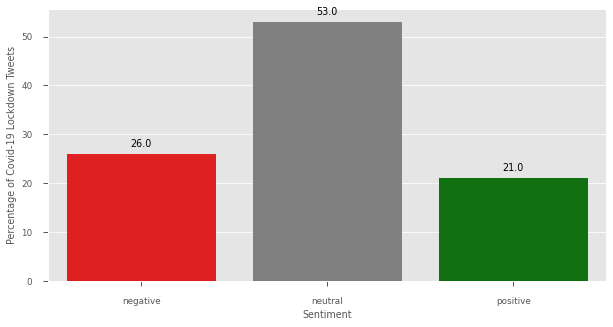

In [27]:
# Visualise percentage of posts with each sentiment

#### Plot settings ####
style.use('seaborn-poster') # sets the size of the charts
style.use('ggplot')
matplotlib.rcParams['font.family'] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_context('paper')

cols = ['red' if label == 'negative' else ('green' if label == 'positive' else 'gray') for label in tweets_per_sentiment['sentiment_label']]
ax = sns.barplot(x="sentiment_label",
                 y="percentage_of_total",
                 data=tweets_per_sentiment,
                 palette=cols
                )

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.set(xlabel='Sentiment', ylabel='Percentage of Covid-19 Lockdown Tweets')

plt.savefig('../Twitter_Output/Twitter_Mar_2023_SentimentChart.png', dpi=400, bbox_inches="tight")

In [28]:
# Word Cloud Function

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def generate_word_cloud(dataframe, category):
    comment_words = ''
    processed_text = dataframe['processed_text']
    
    # iterate through list
    for tweet_text in processed_text:
        # split the text into tokens
        tokens = tweet_text.split()
        # Append tokens to string comment_words
        comment_words += " ".join(tokens)+" "

    # make a word cloud
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='black', colormap='rainbow',
                    #stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the word cloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()
    wordcloud.to_file(f'../Twitter_Output/Twitter_Mar_2023_Wordcloud_{category}.png')

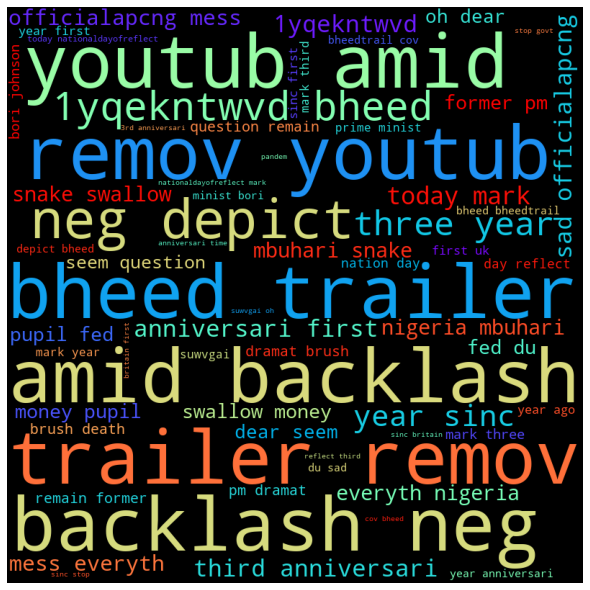

In [29]:
# All Sentiment Word Cloud

generate_word_cloud(tweets, 'all')

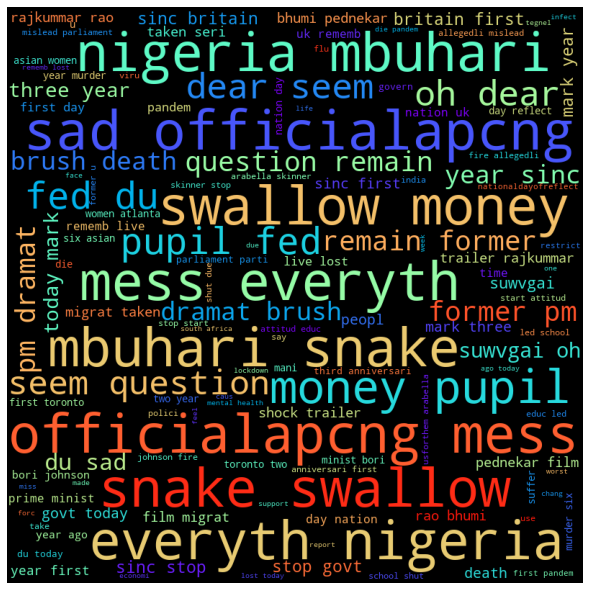

In [30]:
# Negative Sentiment DataFrame

negative = tweets[tweets['sentiment_label'] == 'negative']
generate_word_cloud(negative, 'negative')

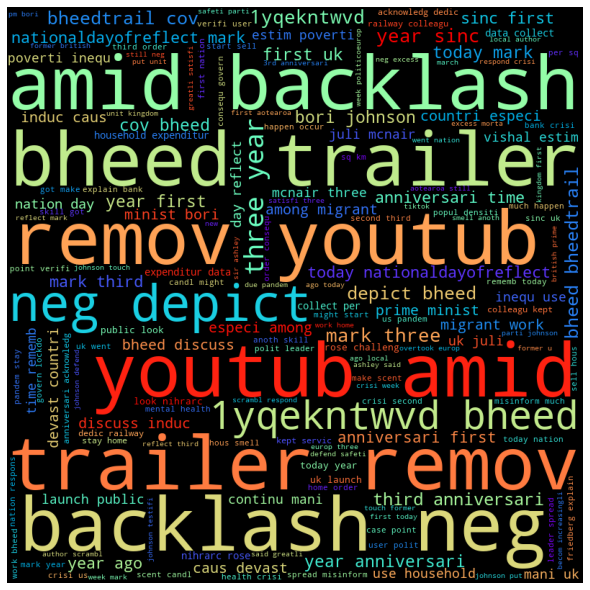

In [31]:
# Neutral Sentiment DataFrame

neutral = tweets[tweets['sentiment_label'] == 'neutral']
generate_word_cloud(neutral, 'neutral')

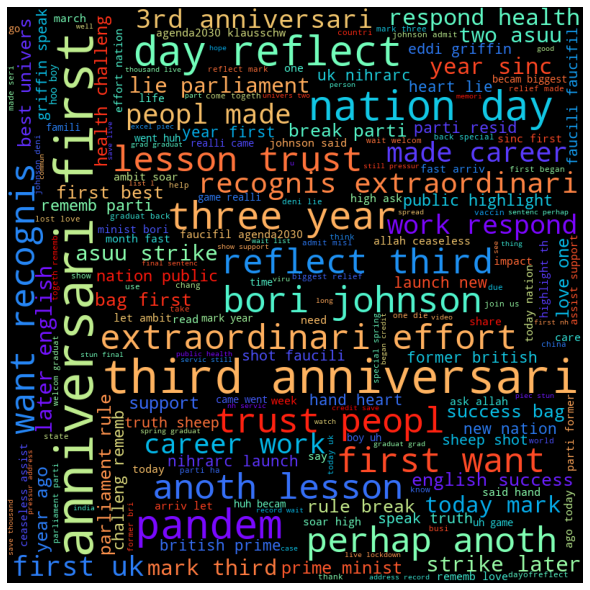

In [32]:
# Positive Sentiment DataFrame

positive = tweets[tweets['sentiment_label'] == 'positive']
generate_word_cloud(positive, 'positive')

In [33]:
# Export to a CSV

# path = "./Twitter_Sentiments/"
# if not os.path.exists(path):
#         os.makedirs(path)

tweets.to_csv('./Twitter_Mar_2023_Sentiments.csv') 